In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

from cobl_diffusion.models.diffusion.diffusion_ddim_cobl import GaussianDiffusion
from cobl_diffusion.modules.diffusionmodules.unet import UNetModel
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import pickle

torch.manual_seed(0)
np.random.seed(0)

In [3]:
HORIZON = 80
DT = 0.1
SCALE_FACTOR = 10.0

In [4]:
unet = UNetModel(
    horizon = HORIZON
).cuda()

diffusion = GaussianDiffusion(
    model = unet,
    horizon = HORIZON,
    dynamics='single'
).cuda()

load_path = '../trained_model/cobl.pt'
data = torch.load(load_path)
state = {k: v for k, v in data['model'].items()
            if not 'loss' in k}
dummy = diffusion.state_dict()
dummy.update(state)
state = dummy
diffusion.load_state_dict(state, strict=False)

[ models/temporal ] Channel dimensions: [(2, 32), (32, 64), (64, 128), (128, 256)]
[(2, 32), (32, 64), (64, 128), (128, 256)]


<All keys matched successfully>

In [5]:
# dataset
batch_ego = torch.load('../dataset/eval80_ego.pt')
with open('../dataset/eval80_obs.pkl', 'rb') as f:
    batch_neigh = pickle.load(f)

In [6]:
idx = 110 # 9
state_ego = batch_ego[idx].unsqueeze(0)
state_neigh = batch_neigh[idx]
nan_mask = torch.isnan(state_neigh).any(dim=(0,2,3))
state_neigh = state_neigh[:, ~nan_mask]

pos_ego = state_ego[:,:2,:]

start = torch.tensor([0, 0])
goal = pos_ego[0,:,-1].cuda()

neigh_plot = state_neigh[:,:,:4,:]
state_neigh_ = state_neigh/SCALE_FACTOR
neigh = state_neigh_[:,:,(0,1,2,3)].cuda() # x, y, dx, dy
rad = 0.5
rad = rad/SCALE_FACTOR

In [7]:
s_cbf = 0.2
s_clf = 0.1

count = 0
u_gens = []
pos_gens = []

start = torch.zeros(2).cuda()
start_norm = start/SCALE_FACTOR
goal_norm = goal/SCALE_FACTOR

pos = torch.cat([torch.linspace(start_norm[0], goal_norm[0], HORIZON-1).unsqueeze(1),
                    torch.linspace(start_norm[1], goal_norm[1], HORIZON-1).unsqueeze(1)], axis=1).cuda()
pos = torch.cat([start_norm.unsqueeze(0).cuda(), pos], axis=0)
pos = pos.unsqueeze(0).transpose(1,2)
u_hist = torch.zeros(1,2,1).cuda()
cond = torch.cat([start_norm.unsqueeze(1), goal_norm.unsqueeze(1)], axis=1).cuda().unsqueeze(0).float()
init_state = torch.zeros(1,3).cuda()
goal_norm = goal_norm.unsqueeze(0)
u_gen, state_gen = diffusion.ddim_sample(init_state, goal_norm, pos.detach(), r=rad, ddim_steps=50, temperature=1.,
                                obst=neigh.detach(), u_hist=u_hist,
                                s_cbf=s_cbf, s_clf=s_clf)

pos_gen = torch.cumsum(0.1*u_gen, dim=2)
pos_gen = torch.cat([start.unsqueeze(0).unsqueeze(-1).cuda(), pos_gen], axis=2)

u_gen = u_gen * SCALE_FACTOR
pos_gen = pos_gen * SCALE_FACTOR
u_gens.append(u_gen)
pos_gens.append(pos_gen)

distance = torch.sqrt(((pos_gen[:,:,1:]-neigh[:,:,:2,:]*SCALE_FACTOR)**2).sum(2))
safe = torch.any(distance<0.5).int()

print(safe)
print((pos_gen[:,:,-1]-goal).norm())

tensor(0, device='cuda:0', dtype=torch.int32)
tensor(0.6434, device='cuda:0')


/tmp/ipykernel_2471290/387839981.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  norm = np.sqrt((xt_n-xt)**2 + (yt_n-yt)**2)


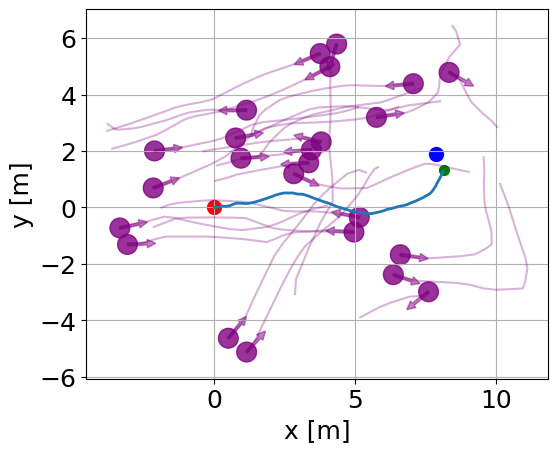

In [8]:
%matplotlib inline
neigh_plot = neigh_plot.detach().cpu()

fig, ax = plt.subplots()
ax.scatter(0,0, c='r', s=100)

for j in range(neigh_plot.shape[1]):
    ax.plot(neigh_plot[0,j,0,:].detach().cpu().numpy(), neigh_plot[0,j,1,:].detach().cpu().numpy(), 
            label="obstacle", lw=1.5, color='purple', alpha=0.3)
    circle = Circle((neigh_plot[0,j,0,0], neigh_plot[0,j,1,0]), 0.35, color='purple', fill=True, alpha=0.8)
    ax.add_patch(circle)

    xt = neigh_plot[0,j,0,0]
    yt = neigh_plot[0,j,1,0]
    xt_n = neigh_plot[0,j,0,5]
    yt_n = neigh_plot[0,j,1,5]
    norm = np.sqrt((xt_n-xt)**2 + (yt_n-yt)**2)
    ax.arrow(x=xt, y=yt, dx=(xt_n-xt)/norm, dy=(yt_n-yt)/norm, width=0.1, head_width=0.3, head_length=0.3, 
            length_includes_head=True, fc='purple', ec='purple', alpha=0.5)


for i in range(len(pos_gens)):
    pos_gen = pos_gens[i]
    ax.scatter(goal.squeeze()[0].detach().cpu().numpy(), goal.squeeze()[1].detach().cpu().numpy(), c='b', s=100)
    ax.plot(pos_gen[0,0,:-1].detach().cpu().numpy(), pos_gen[0,1,:-1].detach().cpu().numpy(), color='C0', label='robot', lw=2)
    ax.scatter(pos_gen[0,0,-1].detach().cpu().numpy(), pos_gen[0,1,-1].detach().cpu().numpy(), c='g', s=50)

plt.xlabel('x [m]', fontsize=18)
plt.ylabel('y [m]', fontsize=18)
ax.grid(True)
plt.gca().set_aspect('equal')
plt.tick_params(axis='both', labelsize=18)
plt.show()